# Datasets muito grandes

Neste momento, estamos tendo problemas ligados ao fato de que precisamos usar muito mais memória do que temos disponível para fazer caber os dados que estamos usando. Neste notebook, vamos usar a API do Keras para lidar com uma grande base de dados.


## Exercício
**Objetivo: entender como a base de dados deve ser armazenada**

Até o momento, usamos bases de dados em grandes arquivos CSV. O problema desse tipo de abordagem é que precisaremos abrir arquivos muito grandes, e isso pode ocupar muita memória, tornando difícil treinarmos classificadores para nossa base.

Analisando o código abaixo, identifique como a base de dados deve ficar organizada no computador para poder ser usada pela API do Keras.

In [40]:
from keras.layers import Input, Dense, Activation, TimeDistributed, Softmax, TextVectorization, Reshape, RepeatVector, GRU, Conv1D, Bidirectional, AveragePooling1D, UpSampling1D, Embedding, Concatenate, GlobalAveragePooling1D, LSTM, Multiply
from keras.models import Model
import pandas as pd
import os
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:

df = pd.read_csv('datasets/IMDB Dataset.csv')
DATASET_DIR = './datasets/frases_classificacao/'


In [3]:
os.mkdir(DATASET_DIR)
os.mkdir(DATASET_DIR + "/train")
os.mkdir(DATASET_DIR + "/train/positive")
os.mkdir(DATASET_DIR + "/train/negative")
os.mkdir(DATASET_DIR + "/test")
os.mkdir(DATASET_DIR + "/test/positive")
os.mkdir(DATASET_DIR + "/test/negative")


In [5]:
reviews = df['review']
labels = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, train_size=0.8)

n_texto = 0
for i in tqdm(range(len(y_train))):
    texto = x_train.iloc[i]
    fname = 'review_' + str(n_texto) + '.txt'
    with open(DATASET_DIR + "/train/" + y_train.iloc[i] + "/" + fname, 'w') as f:
        f.write(texto)
        n_texto += 1

for i in tqdm(range(len(y_test))):
    texto = x_test.iloc[i]
    fname = 'review_' + str(n_texto) + '.txt'
    with open(DATASET_DIR + "/test/" + y_test.iloc[i] + "/" + fname, 'w') as f:
        f.write(texto)
        n_texto += 1

print("Criei textos:", n_texto)


100%|██████████| 10000/10000 [00:16<00:00, 623.98it/s]

Criei textos: 50000


In [51]:
# Ler um dataset e fazer batches
from tensorflow.keras.utils import text_dataset_from_directory

dataset_train = text_dataset_from_directory(
    DATASET_DIR + '/train',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    batch_size=1024,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False
)

dataset_test = text_dataset_from_directory(
    DATASET_DIR+ '/test',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    batch_size=1024,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 40003 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.


## Exercício 2
**Objetivo: entender como funciona a função .map()**

Algumas vezes, precisamos fazer alguns tipos de pré-processamento na base de dados. Para isso, usamos o método `.map()`.  Para que ele é usado, e para que ele está sendo usado no contexto do código abaixo?

In [10]:
from keras.layers import Input, TextVectorization
from keras.models import Model

def remover_label(x,label):
    return x

vocab_size = 10000
vectorize_layer = TextVectorization(max_tokens=vocab_size, output_sequence_length=256)
vectorize_layer.adapt(dataset_train.map(remover_label))

In [11]:
vectorize_layer.get_vocabulary()[0:10]

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it']

## Exercício 3
**Objetivo: usar um dataset para treinar uma rede neural de classificação**

Analisando o código abaixo, identifique:

1. Como usar um dataset para treinar uma rede neural de classificação de textos?
1. Modifique o parâmetro `batch_size` na criação do dataset. Como isso influencia o tempo de execução e o resultado final?
1. Por que não podemos usar `batch_size` infinitamente alto (ou: porque não devemos treinar usando o dataset inteiro em um único batch?)

In [32]:
def convolve_and_downsample(input_n_samples, input_embedding_size, n_filters, kernel_size=3, **kwargs):
    input_layer = Input(shape=(input_n_samples,input_embedding_size))
    x = input_layer
    x = Conv1D( filters=n_filters,
                kernel_size=kernel_size,
                padding='same',
                use_bias=False,
                )(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Activation('elu')(x)
    return Model(input_layer, x, **kwargs)

def deep_cnn_embedding_softmax_model(vectorize_layer, vocab_size=vocab_size, number_of_ngrams=16, n_gram_size=3):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = convolve_and_downsample(256, 2, number_of_ngrams, n_gram_size, name='ngramas')(x)
    x = convolve_and_downsample(128, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(64, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(32, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(16, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(8, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(4, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(2, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = Reshape( (-1,))(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

clf = deep_cnn_embedding_softmax_model(vectorize_layer)
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 256)              0         
 ectorization)                                                   
                                                                 
 projecao (Embedding)        (None, 256, 2)            20000     
                                                                 
 ngramas (Functional)        (None, 128, 16)           96        
                                                                 
 model_34 (Functional)       (None, 64, 16)            768       
                                                                 
 model_35 (Functional)       (None, 32, 16)            768       
                                                          

In [33]:
history = clf.fit(dataset_train, epochs=10, verbose=1, validation_data=dataset_test)


Epoch 1/10
40/40 [==============================] - 32s 632ms/step - loss: 0.6919 - accuracy: 0.5485 - val_loss: 0.6777 - val_accuracy: 0.6287
Epoch 2/10
40/40 [==============================] - 29s 634ms/step - loss: 0.5442 - accuracy: 0.7262 - val_loss: 0.4424 - val_accuracy: 0.7992
Epoch 3/10
40/40 [==============================] - 35s 777ms/step - loss: 0.3946 - accuracy: 0.8245 - val_loss: 0.4050 - val_accuracy: 0.8221
Epoch 4/10
40/40 [==============================] - 31s 690ms/step - loss: 0.3220 - accuracy: 0.8645 - val_loss: 0.3505 - val_accuracy: 0.8424
Epoch 5/10
40/40 [==============================] - 31s 685ms/step - loss: 0.2797 - accuracy: 0.8849 - val_loss: 0.3712 - val_accuracy: 0.8437
Epoch 6/10
40/40 [==============================] - 30s 654ms/step - loss: 0.2550 - accuracy: 0.8978 - val_loss: 0.3131 - val_accuracy: 0.8685
Epoch 7/10
40/40 [==============================] - 29s 646ms/step - loss: 0.2345 - accuracy: 0.9073 - val_loss: 0.3154 - val_accuracy: 0.8754

In [34]:
clf.evaluate(dataset_test)

10/10 [==============================] - 6s 212ms/step - loss: 0.3296 - accuracy: 0.8670


[0.32960501313209534, 0.8669999837875366]

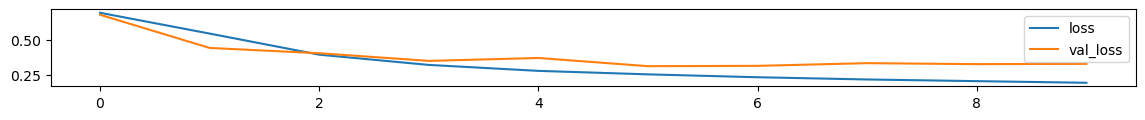

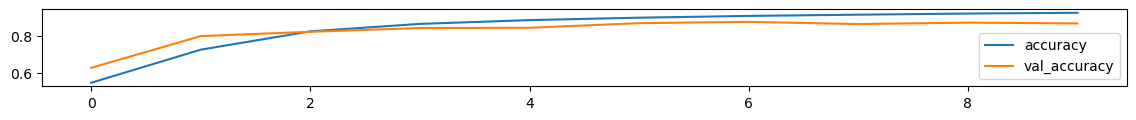

In [35]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


## Exercício 4
**Objetivo: salvar um modelo pré-treinado**

Veja as instruções na [documentação do Keras](https://www.tensorflow.org/guide/keras/save_and_serialize?hl=pt-br) sobre como salvar um modelo pré-treinado.

Modifique o código acima de forma que o treinamento gere dois modelos diferentes:

1. Um extrator de features, que recebe como entrada uma lista de strings e retorna uma representação vetorial de cada uma das strings (isto é, executa a rede até antes da última camada densa),
1. Um classificador, que corresponde à rede inteira.

Após:

1. Passe seu extrator de features para um colega.
1. Use o extrator de features de outro colega, congele seus pesos, e treine um classificador usando seus próprios dados.